__<center>Statistics essentials - Lending club case study assignment </center>__

<center>Read in the loan csv file and clean the data set</center>

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

#function to clean up entries in column titled "emp_title":
#   convert  to all lower case as company names have been used with differes cases
#   Also adjust for variations in mentions of "US", "US Postal service, and "self employed"
def tr_emp_title(x):
      x = str(x)
      x = x.lower()
      x = re.sub(r"united states ","us " ,x)
      x = re.sub(r"\bu\.s\.\B","us" ,x)
      x = re.sub(r"u s ", "us ", x)
      x = re.sub(r"us postal service.*", "usps", x)
      x = re.sub(r"us postal svc.*", "usps", x)
      x = re.sub(r"u.s.p.s", "usps", x)
      x = re.sub(r".*self.*","self employed" ,x)
      return x

#function to find correlation between grouped sizes of two columns of data 
#in two related data sets
def corr_sizes (df1, df2, col):
    return df1.groupby(col).size().corr(df2.groupby(col).size())

#function to plot a histogram. 
#   Categories is the ticks of x axis
#   values is the list whose hist is plotted 
#   Valtxtspace is the spacing for values above  the bars
#   Valtxtrot is amount of rotation for text above the bars
#   Ttile forms the plot heading
def plt_hist(categories, values, valtxtspace, valtxtrot,  title):
    xpos = np.array([x for x, _ in enumerate(categories)])
    width = 0.35
    plt.style.use('ggplot')
    plt.figure(figsize=(10,6))
    bars = plt.bar(xpos, values, width, label='Normal')
    plt.xticks(xpos, categories,rotation = 90 )
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x()+0.06, yval + valtxtspace, yval,rotation = valtxtrot)
    plt.title(title)
    plt.show()
    
############## load csv ###########################################
loans = pd.read_csv('loan.csv')

#Convert interest rate column from string to float and create buckets for uniform analysis
#loans.int_rate = loans.int_rate.apply(lambda x: float(x.strip('%')))

############################ Data Cleaning #################################

#filter out columns that have all NAs
fcols = (loans.columns[loans.apply(lambda col: col.isnull().all())])
loans.drop(fcols, axis=1,inplace=True)


#drop columns with same values in all rows. The code below to do it runs a little slow
#So hardcoding the results from running this commented code 
#fcols = (loans.columns[loans.apply(lambda col: len(set(col)) == 1)])
#additionally, "next_pymnt_d" is being dropped as it has most of the rows empty with only two set of
# date values....
fcols = ['pymnt_plan', 'initial_list_status', 'policy_code', 'application_type', 'acc_now_delinq', 'delinq_amnt','next_pymnt_d']
loans.drop(fcols, axis=1,errors='ignore',inplace=True)

#find the percentage of null values in each column
fcol = list(loans.columns[(loans.isnull().sum()/len(loans.index)*100) > 50])
loans.drop(fcols, axis=1,errors='ignore',inplace=True)

#clean up emp_title column
loans.emp_title = loans.emp_title.apply(lambda x: tr_emp_title(x))

#Convert date columns to appropriate type
fcols = ['issue_d','earliest_cr_line','last_pymnt_d','last_credit_pull_d']
loans[fcols]=loans[fcols].apply(pd.to_datetime,format='%b-%y')


#Convert interest rate column from string to float and create buckets for uniform analysis
loans.int_rate = loans.int_rate.apply(lambda x: float(x.strip('%')))
loans.revol_util = loans.revol_util.apply(lambda x: float(str(x).strip('%')))

print ("Number of columns left to analyze after data cleaning: {}".format(loans.shape[1] ))

Number of columns left to analyze after data cleaning: 50


<center>Pick the columns for univariate analysis and bivariate analysis with loan_status</center>

In [2]:
#create 3 data sets one each for "Fully Paid", "Current", and "Charged-Off (defaulters)" customers
loans_chd_off = loans[loans.loan_status == 'Charged Off']
loans_current = loans[loans.loan_status == 'Current']
loans_fy_paid = loans[loans.loan_status == 'Fully Paid']

#For each column, see how the values in each of the columns correlate between defaulters table vs fully paid data set.
#    This can be done by correlating the "size" of groupby output for each column in the two data sets
#    High correlation implies that the column cannot be used for predicting defaulters since proportionally
#    there are fair share of defaulters and "fully paid" customers having those column attributes
fcols = list(loans.columns)
corr_list = list(map(lambda x: corr_sizes(loans_chd_off, loans_fy_paid, x), fcols))
correlations = pd.Series(corr_list, index = fcols)

print("Correlation table of column values from defaulters and fully paid dataset:\n{}".format(correlations.sort_values()))

analysis_columns = ['int_rate', 'installment', 'grade', 'sub_grade', 'verification_status', 
                    'zip_code', 'dti', 'earliest_cr_line', 'annual_income', 'addr_state', 
                    'inq_last_6mths', 'total_acc', 'funded_amnt_inv', 'loan_amnt', 'funded_amnt', 
                    'purpose', 'emp_length', 'home_ownership', 'open_acc', 'pub_rec', 
                    'pub_rec_bankruptcies', 'term', 'revol_util']
print("\nColumns selected for analysis:")
print(*analysis_columns, sep = "\n")


Correlation table of column values from defaulters and fully paid dataset:
total_rec_int                -0.006891
last_pymnt_amnt               0.132330
installment                   0.361361
dti                           0.411071
grade                         0.684954
last_pymnt_d                  0.689099
sub_grade                     0.713068
int_rate                      0.752485
verification_status           0.808731
revol_util                    0.816207
mths_since_last_delinq        0.827632
zip_code                      0.911849
earliest_cr_line              0.928300
issue_d                       0.965916
last_credit_pull_d            0.968157
annual_inc                    0.973542
title                         0.974970
inq_last_6mths                0.981278
total_acc                     0.981703
funded_amnt_inv               0.982186
loan_amnt                     0.982977
mths_since_last_record        0.983302
funded_amnt                   0.985390
addr_state                  

__NOTEs:__ <br>
Not going big on outlier removal as in most cases that data seems useful in arriving at some decisions<br>
Where required outlier removal is done on filtered data sets directly altough it less than ideal in some cases<br>
In some cases hard coding of values have been preferred just to save coding time and focus on concepts under study<br>

<center>Analysis of int_rate column</center>

count    5627.000000
mean       13.820432
std         3.654413
min         5.420000
25%        11.310000
50%        13.610000
75%        16.400000
max        24.400000
Name: int_rate, dtype: float64
count    32950.000000
mean        11.609761
std          3.599964
min          5.420000
25%          8.490000
50%         11.490000
75%         13.990000
max         24.110000
Name: int_rate, dtype: float64


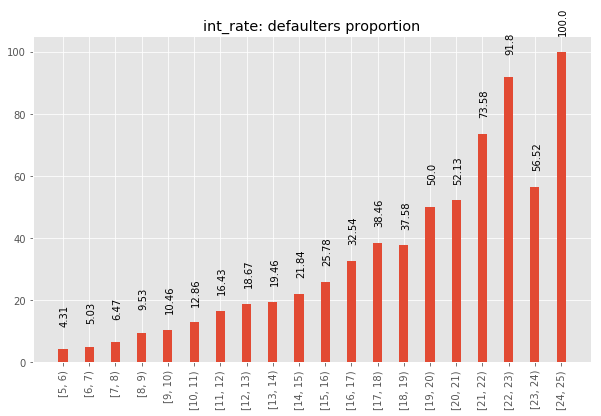

In [3]:
#Analysis of int_rate column: 
print(loans_chd_off.int_rate.describe())
print(loans_fy_paid.int_rate.describe())
#      bin the interest rates into 1 percentage point categories from 5 to 25 for uniformity
#      Find the number of defaulters and fully paid entries in each of the bins
#      plot the proportion of defaulters to fully paid
loans_chd_off['int_rate_bin'] = pd.cut(loans_chd_off.int_rate, list(range(5,26,1)), right=False)
loans_fy_paid['int_rate_bin'] = pd.cut(loans_fy_paid.int_rate, list(range(5,26,1)), right=False)
bins1 = loans_chd_off.groupby('int_rate_bin').size()
bins2 = loans_fy_paid.groupby('int_rate_bin').size()
values = list(map(lambda x,y: round((x*100)/y,2), bins1, bins2 ))
cats = loans_chd_off.groupby('int_rate_bin').size().index.categories
plt_hist(cats, values, 12, 90, "int_rate: defaulters proportion")

__Analysis summary of int_rate:__<br>
From the plot shown it is clear that higher the interest rate higher the risk of loan default<br>
Higher the interest rate higher the risk of loan default<br>
	Loans with Interest rates greater than 20% are especially risky<br>
	Loads with Interest rate less than 14% are very safe<br>

<center>Analysis of grade column</center>

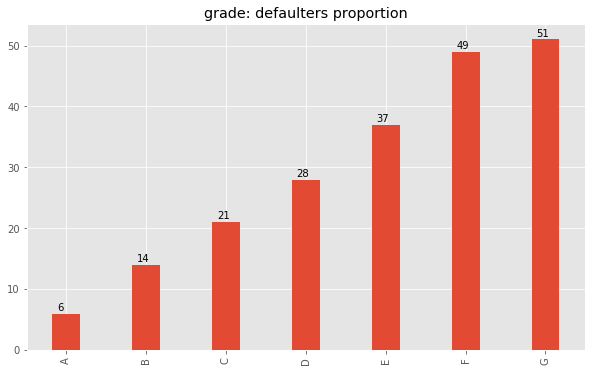

In [4]:
#analysis of grade column:
#      Find the number of defaulters and fully paid entries in each of the grade
#      plot the proportion of defaulters to fully paid
bins1 = loans_chd_off.groupby('grade').size()
bins2 = loans_fy_paid.groupby('grade').size()
values = list(map(lambda x,y: round((x*100)/y), bins1, bins2 ))
cats = loans_chd_off.groupby('grade').size().index
plt_hist(cats, values, 0.5, 0, "grade: defaulters proportion")

__Analysis summary of grade:__<br>
From the plot shown it is clear that risk of default consistently increases across the grades from A to G <br>
Loans graded A and B have very low risk <br>
Loans graded F and G carry high risk<br>

<center>Analysis of sub_grade column</center>

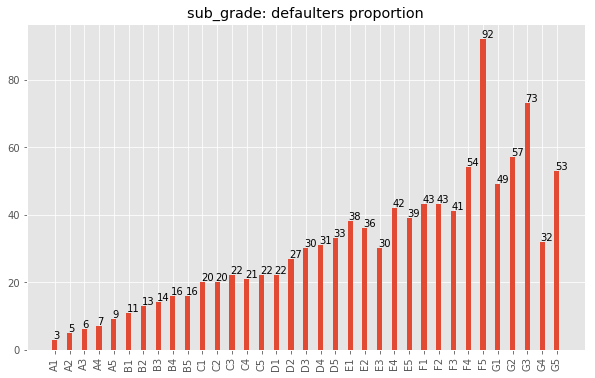

In [5]:
#analysis of sub_grade column:
#      Find the number of defaulters and fully paid entries in each of the sub_grade
#      plot the proportion of defaulters to fully paid
bins1 = loans_chd_off.groupby('sub_grade').size()
bins2 = loans_fy_paid.groupby('sub_grade').size()
values = list(map(lambda x,y: round((x*100)/y), bins1, bins2 ))
cats = loans_chd_off.groupby('sub_grade').size().index
plt_hist(cats, values, 0.5, 0, "sub_grade: defaulters proportion")

__Analysis summary of sub_grade:__<br>
From the plot shown it is clear that risk of default follows the trend seen with load grades.<br> 
Within a grade, risk of default generally increases across subgrades 1-5 for grades A, B, C, and D. No such pattern in grades E, F, and G<br>
Loans graded at F5 and G3 are especially risky

<center>Analysis of installment column</center>

count    5627.000000
mean      336.175006
std       217.051841
min        22.790000
25%       168.555000
50%       293.870000
75%       457.840000
max      1305.190000
Name: installment, dtype: float64
count    32950.000000
mean       320.125232
std        207.081110
min         15.690000
25%        165.282500
50%        275.650000
75%        420.735000
max       1295.210000
Name: installment, dtype: float64
installment_bin
[10, 110)        699
[110, 210)      1224
[210, 310)      1058
[310, 410)       981
[410, 510)       580
[510, 610)       415
[610, 710)       272
[710, 810)       138
[810, 910)       176
[910, 1010)       61
[1010, 1110)       6
[1110, 1210)      10
[1210, 1310)       7
dtype: int64
installment_bin
[10, 110)       4038
[110, 210)      7973
[210, 310)      6494
[310, 410)      5855
[410, 510)      3270
[510, 610)      1942
[610, 710)      1463
[710, 810)       724
[810, 910)       803
[910, 1010)      185
[1010, 1110)      78
[1110, 1210)      80
[1210, 1310)      

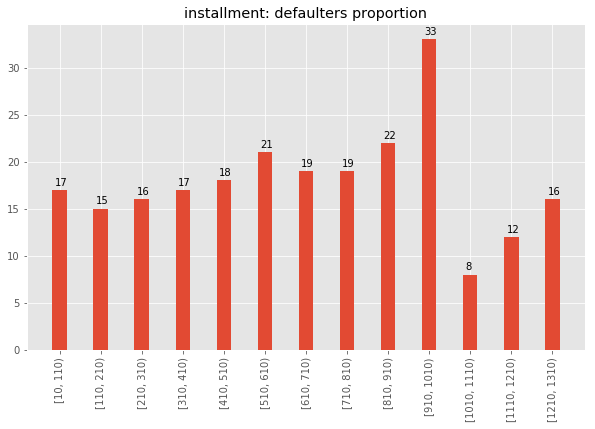

In [6]:
#analysis of installment column:
print(loans_chd_off.installment.describe())
print(loans_fy_paid.installment.describe())
#      bin the interest rates into installment amounts of 100 for uniformity
#      Find the number of defaulters and fully paid entries in each of the bins
#      plot the proportion of defaulters to fully paid
loans_chd_off['installment_bin'] = pd.cut(loans_chd_off.installment, list(range(10,1350,100)), right=False)
loans_fy_paid['installment_bin'] = pd.cut(loans_fy_paid.installment, list(range(10,1350,100)), right=False)
bins1 = loans_chd_off.groupby('installment_bin').size()
bins2 = loans_fy_paid.groupby('installment_bin').size()
print(bins1)
print(bins2)
values = list(map(lambda x,y: round((x*100)/y), bins1, bins2 ))
cats = loans_chd_off.groupby('installment_bin').size().index.categories
plt_hist(cats, values, 0.5, 0, "installment: defaulters proportion")

__Analysis summary of installment:__<br>
From the plot shown there is no clear pattern of defaulters proportion based on installment amount<br>
There is a spike in defaulters proportion for installment amount of 910-1010 that can be investigated further<br>
None based on the installment amount column

<center>Analysis of verification_status column</center>

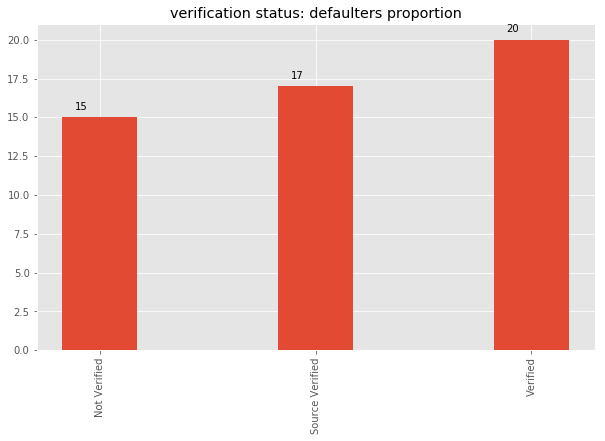

In [7]:
#analysis of verification_status column:
#      Find the number of defaulters and fully paid entries in each of the verification gropus
#      plot the proportion of defaulters to fully paid
bins1 = loans_chd_off.groupby('verification_status').size()
bins2 = loans_fy_paid.groupby('verification_status').size()
values = list(map(lambda x,y: round((x*100)/y), bins1, bins2 ))
cats = loans_chd_off.groupby('verification_status').size().index
plt_hist(cats, values, 0.5, 0, "verification status: defaulters proportion")

__Analysis summary of verification_status:__<br>
Even though there is a slight increasing trend in defaulters proportion  across categories, it is not significant<br>
Interestingly verified loans are showing higher tendency of defaulting. Something to study further closely<br>

<center>Analysis of zip_code column</center>

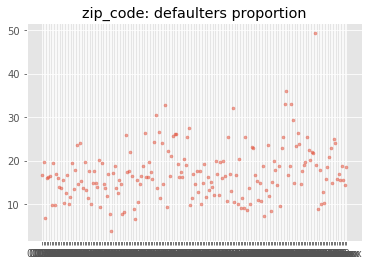


List of high defaulters risk zip codes:
    zip_code  chd_off  fully_paid  defaulters_proportion
765    935xx     33.0        67.0              49.253731
727    891xx     64.0       178.0              35.955056
726    890xx     32.0        97.0              32.989691
738    906xx     26.0        79.0              32.911392
292    325xx     20.0        61.0              32.786885
535    641xx     26.0        81.0              32.098765
270    302xx     26.0        85.0              30.588235

List of low defaulters risk zip codes:
    zip_code  chd_off  fully_paid  defaulters_proportion
144    170xx      2.0        52.0               3.846154
189    220xx      7.0       107.0               6.542056
8      017xx      5.0        74.0               6.756757
651    787xx     12.0       165.0               7.272727
173    200xx     15.0       196.0               7.653061
126    152xx      9.0       117.0               7.692308
174    201xx     17.0       206.0               8.252427
666    

In [8]:
#analysis of zip_code column:
#      Find the number of defaulters and fully paid entries in each of the zip codes
#      Select entries where fully paid entries are greater than 50 to get a fair data. 
#      plot the proportion of defaulters to fully paid as a scatter plot
#      This plot shows clustering of defaulters proportion around 10-30%. 
#      Zip codes above the cluster can be thought of high risk and those below as low risk
bins1 = loans_chd_off.groupby('zip_code').size()
bins2 = loans_fy_paid.groupby('zip_code').size()

df1 = (pd.concat([bins1, bins2], axis=1).reset_index()).dropna()
df1.columns=['zip_code','chd_off','fully_paid']
df1['defaulters_proportion'] = (df1.chd_off*100)/df1.fully_paid
df1 = df1[df1.fully_paid > 50]

area = np.pi*3
plt.scatter(df1.zip_code, df1.defaulters_proportion, s=area,alpha=0.5)
plt.title("zip_code: defaulters proportion")
plt.show()

print("\nList of high defaulters risk zip codes:\n{}".format ((df1[df1.defaulters_proportion > 30]).sort_values(by=['defaulters_proportion'],ascending=False)))
print("\nList of low defaulters risk zip codes:\n{}".format ((df1[df1.defaulters_proportion < 10]).sort_values(by=['defaulters_proportion'])))

__Analysis summary for zip_code:__<br>
From the plot, if defaulters proportion of 10 to 30 can be considered as an average cluster then, loan by applicants from zip codes below the cluster can be considered safe.<br>
Loan by applicants from zip codes above the normal cluster can be considered riskier. One zip code particularly seems far above the cluster – 935XX and could be subject of further analysis.<br>
Loan applications from certain zip codes can be classified risky based on further research.

<center>Analysis of dti column</center>

count    5627.000000
mean       14.000624
std         6.585577
min         0.000000
25%         9.050000
50%        14.290000
75%        19.290000
max        29.850000
Name: dti, dtype: float64
count    32950.000000
mean        13.148421
std          6.680041
min          0.000000
25%          7.980000
50%         13.200000
75%         18.390000
max         29.990000
Name: dti, dtype: float64
dti_bin
[0, 1)      110
[1, 2)      118
[2, 3)      115
[3, 4)      134
[4, 5)      148
[5, 6)      145
[6, 7)      184
[7, 8)      200
[8, 9)      232
[9, 10)     240
[10, 11)    255
[11, 12)    248
[12, 13)    290
[13, 14)    298
[14, 15)    308
[15, 16)    268
[16, 17)    299
[17, 18)    259
[18, 19)    289
[19, 20)    279
[20, 21)    262
[21, 22)    237
[22, 23)    232
[23, 24)    212
[24, 25)    178
[25, 26)     27
[26, 27)     17
[27, 28)     19
[28, 29)     13
dtype: int64
dti_bin
[0, 1)       848
[1, 2)       755
[2, 3)       816
[3, 4)       892
[4, 5)      1108
[5, 6)      1183
[6, 7)   

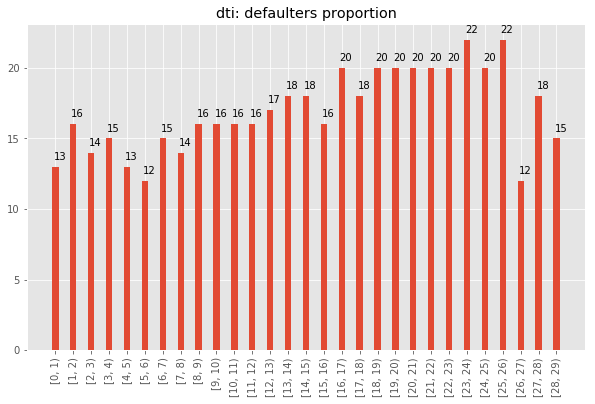

In [9]:
#analysis of dti column:
print(loans_chd_off.dti.describe())
print(loans_fy_paid.dti.describe())
#      bin the dti scores into 1 point ranges from 0 to 30 for uniformity
#      Find the number of defaulters and fully paid entries in each of the bins
#      plot the proportion of defaulters to fully paid
loans_chd_off['dti_bin'] = pd.cut(loans_chd_off.dti, list(range(0,30,1)), right=False)
loans_fy_paid['dti_bin'] = pd.cut(loans_fy_paid.dti, list(range(0,30,1)), right=False)
bins1 = loans_chd_off.groupby('dti_bin').size()
bins2 = loans_fy_paid.groupby('dti_bin').size()
print(bins1)
print(bins2)
values = list(map(lambda x,y: round((x*100)/y), bins1, bins2 ))
cats = loans_chd_off.groupby('dti_bin').size().index.categories
plt_hist(cats, values, 0.5, 0, "dti: defaulters proportion")

__Analysis summary for dti:__<br>
From the plot, there is an ever so slight increase in defaulter’s proportion with higher dti ratios.<br>
However, the lower defaulters proportions at the highest values of dti ratios would point to very minimal correlation of dti ratios to loan default.<br>
This is little surprising as one would expect higher dti to result in higher defaults – Needs further sudy

<center>Analysis of earliest_cr_line column</center>

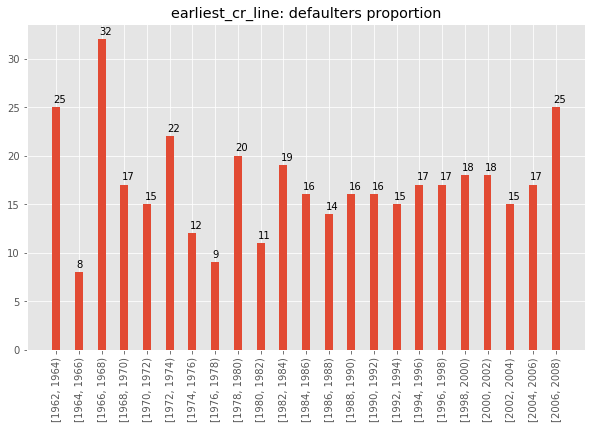

In [10]:
#analysis of earliest_cr_line column:
#   Extract year from earliest_cr_line column, adjust for %y interpreting years less than 1969 as 2069
#   bin the years into periods of 2 for uniformity. Filtering bins with zeroes (hard coded, fix later)
#   Find the number of defaulters and fully paid entries in each of the bins
#   plot the proportion of defaulters to fully paid
loans_chd_off['ecl_year'] = loans_chd_off.earliest_cr_line.dt.year
loans_chd_off.ecl_year = loans_chd_off.ecl_year.apply(lambda x: x if x < 2020 else x-100)

loans_fy_paid['ecl_year'] = loans_fy_paid.earliest_cr_line.dt.year
loans_fy_paid.ecl_year = loans_fy_paid.ecl_year.apply(lambda x: x if x < 2020 else x-100)

loans_chd_off['ecl_year_bin'] = pd.cut(loans_chd_off.ecl_year, list(range(1940,2010,2)), right=False)
loans_fy_paid['ecl_year_bin'] = pd.cut(loans_fy_paid.ecl_year, list(range(1940,2010,2)), right=False)
bins1 = loans_chd_off.groupby('ecl_year_bin').size()[11:]
bins2 = loans_fy_paid.groupby('ecl_year_bin').size()[11:]
values = list(map(lambda x,y: round((x*100)/y), bins1, bins2 ))
cats = loans_chd_off.groupby('ecl_year_bin').size().index.categories[11:]
plt_hist(cats, values, 0.5, 0, "earliest_cr_line: defaulters proportion")

__Analysis summary for earliest_cr_line:__ <br>
No particuar pattern observed in defaulters proportion

<center>Analysis of annual_inc column</center>

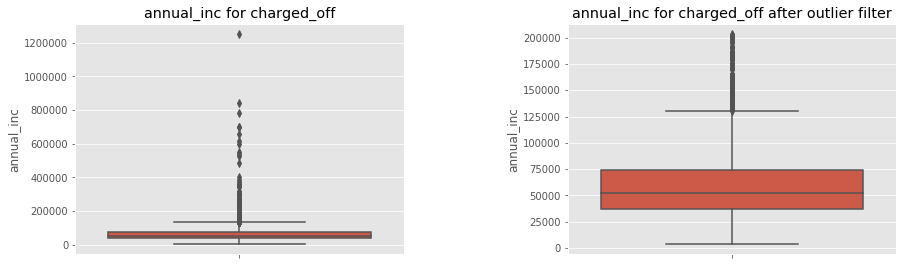

annual_inc_bin
[4000, 14000)        79
[14000, 24000)      275
[24000, 34000)      700
[34000, 44000)      950
[44000, 54000)      842
[54000, 64000)      782
[64000, 74000)      538
[74000, 84000)      414
[84000, 94000)      285
[94000, 104000)     201
[104000, 114000)    115
[114000, 124000)    116
[124000, 134000)     76
[134000, 144000)     50
[144000, 154000)     45
[154000, 164000)     37
[164000, 174000)     10
[174000, 184000)     25
[184000, 194000)     13
[194000, 204000)     17
dtype: int64
annual_inc_bin
[4000, 14000)        228
[14000, 24000)      1203
[24000, 34000)      3293
[34000, 44000)      4576
[44000, 54000)      4754
[54000, 64000)      4379
[64000, 74000)      3456
[74000, 84000)      2751
[84000, 94000)      2053
[94000, 104000)     1653
[104000, 114000)     990
[114000, 124000)     916
[124000, 134000)     629
[134000, 144000)     405
[144000, 154000)     377
[154000, 164000)     213
[164000, 174000)     162
[174000, 184000)     178
[184000, 194000)      92
[1

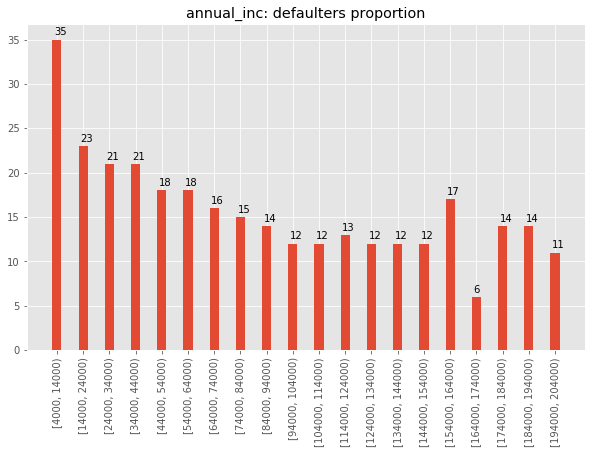

In [11]:
#analysis of annual_inc column:
#print(loans_chd_off.annual_inc.describe())
#print(loans_fy_paid.annual_inc.describe())

import seaborn as sns
plt.subplot(1, 2, 1)
plt.title("annual_inc for charged_off")
sns.boxplot(y='annual_inc', data=loans_chd_off)

#remove outliers - This should ideally be done on the original data frame and then filter
loans_chd_off_f = loans_chd_off[loans_chd_off.annual_inc < loans_chd_off.annual_inc.quantile(0.99)]
loans_fy_paid_f = loans_fy_paid[loans_fy_paid.annual_inc < loans_fy_paid.annual_inc.quantile(0.99)]

plt.subplot(1, 2, 2)
plt.title("annual_inc for charged_off after outlier filter")
sns.boxplot(y='annual_inc', data=loans_chd_off_f)
plt.subplots_adjust(left=0.1, bottom=0.1, right=2.0, top=0.9, wspace=0.5, hspace=0.2)
plt.show()

loans_chd_off_f['annual_inc_bin'] = pd.cut(loans_chd_off_f.annual_inc, list(range(4000,250000,10000)), right=False)
loans_fy_paid_f['annual_inc_bin'] = pd.cut(loans_fy_paid_f.annual_inc, list(range(4000,250000,10000)), right=False)

#remove bins with 0s that give divide by 0 exception. Improvement scope: dont hard code
bins1 = loans_chd_off_f.groupby('annual_inc_bin').size()[:-4]
bins2 = loans_fy_paid_f.groupby('annual_inc_bin').size()[:-4]

print(bins1)
print(bins2)

values = list(map(lambda x,y: round((x*100)/y), bins1, bins2 ))
cats = loans_chd_off_f.groupby('annual_inc_bin').size().index.categories[:-4]
plt_hist(cats, values, 0.5, 0, "annual_inc: defaulters proportion")

__Analysis summary for annual_inc:__<br>
From the plot, it is clear that lower income applicants tend to default more<br>
Applicants with lower annual income especially in the range of 4000 to 14000 are more likely to default on the loan

<center>Analysis of loan_amnt column</center>

loan_amnt_bin
[800, 2800)       395
[2800, 4800)      568
[4800, 6800)      779
[6800, 8800)      633
[8800, 10800)     632
[10800, 12800)    456
[12800, 14800)    283
[14800, 16800)    488
[16800, 18800)    233
[18800, 20800)    317
[20800, 22800)    133
[22800, 24800)    134
[24800, 26800)    286
[26800, 28800)     31
[28800, 30800)     82
[30800, 32800)     18
[32800, 34800)      9
dtype: int64
loan_amnt_bin
[800, 2800)       2256
[2800, 4800)      3726
[4800, 6800)      5447
[6800, 8800)      4008
[8800, 10800)     4208
[10800, 12800)    2999
[12800, 14800)    1686
[14800, 16800)    2594
[16800, 18800)    1053
[18800, 20800)    1636
[20800, 22800)     497
[22800, 24800)     639
[24800, 26800)    1151
[26800, 28800)     176
[28800, 30800)     318
[30800, 32800)      53
[32800, 34800)      42
dtype: int64


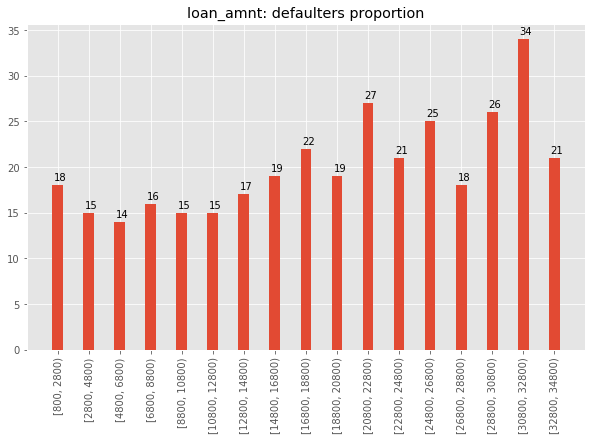

In [12]:
#following same techniques as explained in comments above
loans_chd_off['loan_amnt_bin'] = pd.cut(loans_chd_off.loan_amnt, list(range(800,36000,2000)), right=False)
loans_fy_paid['loan_amnt_bin'] = pd.cut(loans_fy_paid.loan_amnt, list(range(800,36000,2000)), right=False)
bins1 = loans_chd_off.groupby('loan_amnt_bin').size()
bins2 = loans_fy_paid.groupby('loan_amnt_bin').size()
print(bins1)
print(bins2)
values = list(map(lambda x,y: round((x*100)/y), bins1, bins2 ))
cats = loans_chd_off.groupby('loan_amnt_bin').size().index.categories
plt_hist(cats, values, 0.5, 0, "loan_amnt: defaulters proportion")

__Analysis symmary for loan_amnt:__<br>
From the plot shown it appears that there is an upward trend to default loan as the loan amount increases. However this does not appear to be a very clear trend.<br>
Loans with higher amount are comparatively riskier.

<center>Analysis of total_acc column</center>

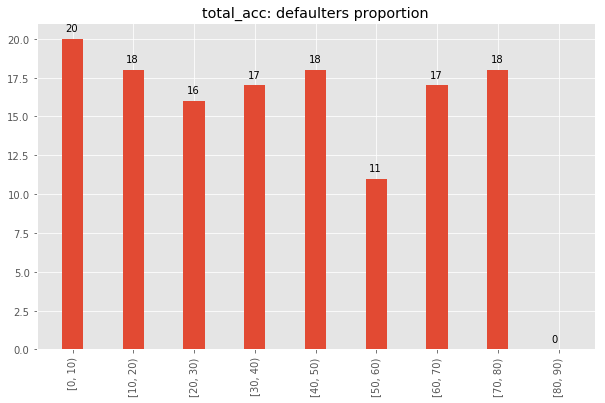

In [13]:
loans_chd_off['total_acc_bin'] = pd.cut(loans_chd_off.total_acc, list(range(0,100,10)), right=False)
loans_fy_paid['total_acc_bin'] = pd.cut(loans_fy_paid.total_acc, list(range(0,100,10)), right=False)
bins1 = loans_chd_off.groupby('total_acc_bin').size()
bins2 = loans_fy_paid.groupby('total_acc_bin').size()
values = list(map(lambda x,y: round((x*100)/y), bins1, bins2 ))
cats = loans_chd_off.groupby('total_acc_bin').size().index.categories
plt_hist(cats, values, 0.5, 0, "total_acc: defaulters proportion")

__Analysis summary for total_acc:__<br>
No particuar pattern observed in defaulters proportion

<center>Analysis of funded_amnt_inv column</center>

funded_amnt_inv_bin
[0, 1000)         106
[1000, 2000)      247
[2000, 3000)      298
[3000, 4000)      344
[4000, 5000)      388
[5000, 6000)      416
[6000, 7000)      315
[7000, 8000)      324
[8000, 9000)      287
[9000, 10000)     321
[10000, 11000)    266
[11000, 12000)    219
[12000, 13000)    256
[13000, 14000)    144
[14000, 15000)    226
[15000, 16000)    243
[16000, 17000)    131
[17000, 18000)    117
[18000, 19000)    107
[19000, 20000)    169
[20000, 21000)    101
[21000, 22000)     66
[22000, 23000)     60
[23000, 24000)     79
[24000, 25000)    131
[25000, 26000)     40
[26000, 27000)     12
[27000, 28000)     16
[28000, 29000)     13
[29000, 30000)     30
[30000, 31000)     27
[31000, 32000)      3
[32000, 33000)      6
[33000, 34000)      8
[34000, 35000)     90
dtype: int64
funded_amnt_inv_bin
[0, 1000)          476
[1000, 2000)      1254
[2000, 3000)      1675
[3000, 4000)      2061
[4000, 5000)      2558
[5000, 6000)      2601
[6000, 7000)      2395
[7000, 8000)    

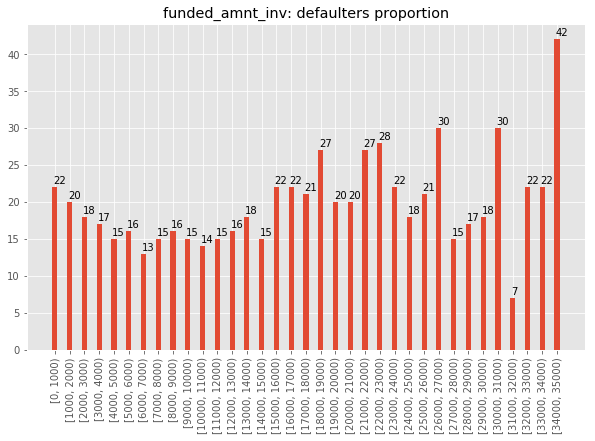

In [14]:
loans_chd_off.funded_amnt_inv.describe()
loans_chd_off['funded_amnt_inv_bin'] = pd.cut(loans_chd_off.funded_amnt_inv, list(range(0,36000,1000)), right=False)
loans_fy_paid['funded_amnt_inv_bin'] = pd.cut(loans_fy_paid.funded_amnt_inv, list(range(0,36000,1000)), right=False)
bins1 = loans_chd_off.groupby('funded_amnt_inv_bin').size()
bins2 = loans_fy_paid.groupby('funded_amnt_inv_bin').size()
print(bins1)
print(bins2)
values = list(map(lambda x,y: round((x*100)/y), bins1, bins2 ))
cats = loans_chd_off.groupby('funded_amnt_inv_bin').size().index.categories
plt_hist(cats, values, 0.5, 0, "funded_amnt_inv: defaulters proportion")

__Analysis summary for funded_amnt and funded_amnt_inv:__<br>
From the plot shown it can be seen that funded amounts in the right side half have higher proportions of defaulters compared to the left side half.<br>
“funded_amnt_inv” shows the same trends as “funded_amnt”.<br>
Loans with higher funded_amount tend to default more.

<center>Analysis of funded_amnt column</center>

funded_amnt_bin
[0, 1000)           1
[1000, 2000)      177
[2000, 3000)      249
[3000, 4000)      289
[4000, 5000)      328
[5000, 6000)      414
[6000, 7000)      335
[7000, 8000)      309
[8000, 9000)      326
[9000, 10000)     219
[10000, 11000)    435
[11000, 12000)    107
[12000, 13000)    371
[13000, 14000)    116
[14000, 15000)    169
[15000, 16000)    322
[16000, 17000)    183
[17000, 18000)     90
[18000, 19000)    158
[19000, 20000)     62
[20000, 21000)    236
[21000, 22000)     76
[22000, 23000)     62
[23000, 24000)     26
[24000, 25000)     94
[25000, 26000)    215
[26000, 27000)     17
[27000, 28000)     14
[28000, 29000)     14
[29000, 30000)      8
[30000, 31000)     59
[31000, 32000)      7
[32000, 33000)      5
[33000, 34000)      4
[34000, 35000)      4
dtype: int64
funded_amnt_bin
[0, 1000)           11
[1000, 2000)       992
[2000, 3000)      1422
[3000, 4000)      1903
[4000, 5000)      2166
[5000, 6000)      2614
[6000, 7000)      2620
[7000, 8000)      2003
[

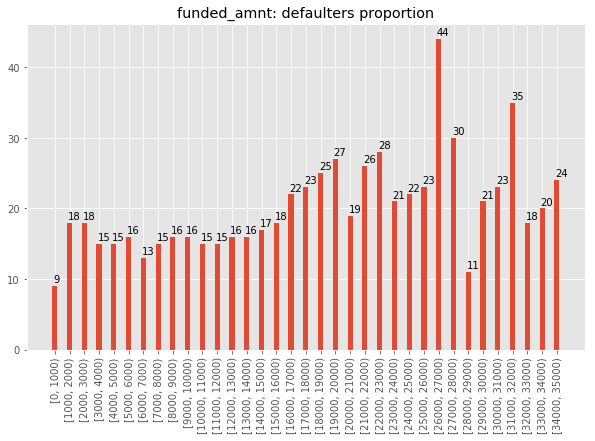

In [15]:
loans_chd_off.funded_amnt.describe()
loans_chd_off['funded_amnt_bin'] = pd.cut(loans_chd_off.funded_amnt, list(range(0,36000,1000)), right=False)
loans_fy_paid['funded_amnt_bin'] = pd.cut(loans_fy_paid.funded_amnt, list(range(0,36000,1000)), right=False)
bins1 = loans_chd_off.groupby('funded_amnt_bin').size()
bins2 = loans_fy_paid.groupby('funded_amnt_bin').size()
print(bins1)
print(bins2)
values = list(map(lambda x,y: round((x*100)/y), bins1, bins2 ))
cats = loans_chd_off.groupby('funded_amnt_bin').size().index.categories
plt_hist(cats, values, 0.5, 0, "funded_amnt: defaulters proportion")

__Analysis summary for funded_amnt and funded_amnt_inv:__<br>
From the plot shown it can be seen that funded amounts in the right side half have higher proportions of defaulters compared to the left side half.<br>
“funded_amnt_inv” shows the same trends as “funded_amnt”.<br>
Loans with higher funded_amount tend to default more.

<center>Analysis of purpose column</center>

purpose
car                    160
credit_card            542
debt_consolidation    2767
educational             56
home_improvement       347
house                   59
major_purchase         222
medical                106
moving                  92
other                  633
renewable_energy        19
small_business         475
vacation                53
wedding                 96
dtype: int64
purpose
car                    1339
credit_card            4485
debt_consolidation    15288
educational             269
home_improvement       2528
house                   308
major_purchase         1928
medical                 575
moving                  484
other                  3232
renewable_energy         83
small_business         1279
vacation                322
wedding                 830
dtype: int64


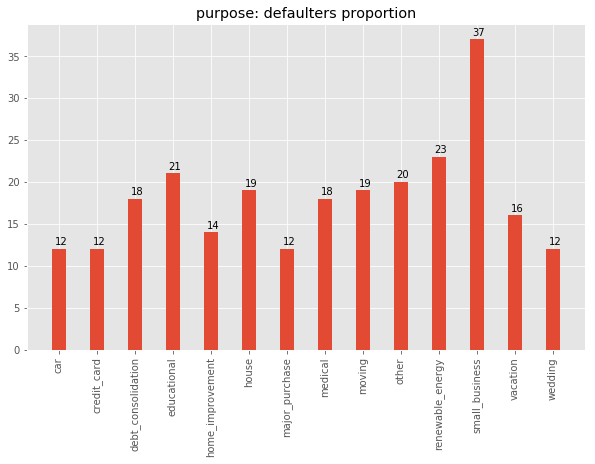

In [16]:
bins1 = loans_chd_off.groupby('purpose').size()
bins2 = loans_fy_paid.groupby('purpose').size()
print(bins1)
print(bins2)
values = list(map(lambda x,y: round((x*100)/y), bins1, bins2 ))
cats = loans_chd_off.groupby('purpose').size().index
plt_hist(cats, values, 0.5, 0, "purpose: defaulters proportion")

__Analysis summary for purpose:__<br>
From the plot shown it is clear that loans taken under small business category has significantly higher proportion of defaulters<br>
Loans for small business purposes carry significantly high risks

<center>Analysis of emp_length column</center>

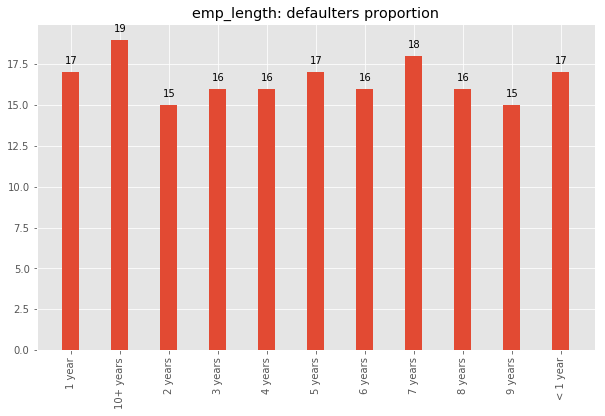

In [17]:
bins1 = loans_chd_off.groupby('emp_length').size()
bins2 = loans_fy_paid.groupby('emp_length').size()
values = list(map(lambda x,y: round((x*100)/y), bins1, bins2 ))
cats = loans_chd_off.groupby('emp_length').size().index
plt_hist(cats, values, 0.5, 0, "emp_length: defaulters proportion")

__Analysis summary for emp_length:__<br>
No particuar pattern observed in defaulters proportion

<center>Analysis of home_ownership column</center>

home_ownership
MORTGAGE    14694
OTHER          80
OWN          2532
RENT        15641
dtype: int64


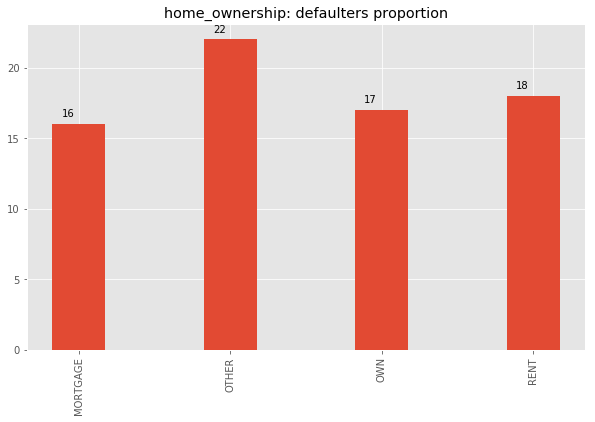

In [18]:
bins1 = loans_chd_off.groupby('home_ownership').size()
bins2 = loans_fy_paid.groupby('home_ownership').size().drop('NONE')
print(bins2)
values = list(map(lambda x,y: round((x*100)/y), bins1, bins2 ))
cats = loans_chd_off.groupby('home_ownership').size().index
plt_hist(cats, values, 0.5, 0, "home_ownership: defaulters proportion")

__Analysis summary for home_ownership:__<br>
It appears that applicants with home ownership of "OTHER" seem to marginally have higher loan defaults.<br>
However the number of sample for that category is also low

<center>Analysis of open_acc column</center>

open_acc_bin
[2, 4)       385
[4, 6)       789
[6, 8)      1100
[8, 10)     1064
[10, 12)     847
[12, 14)     564
[14, 16)     385
[16, 18)     207
[18, 20)     127
[20, 22)      79
dtype: int64
open_acc_bin
[2, 4)      1681
[4, 6)      4622
[6, 8)      6655
[8, 10)     6357
[10, 12)    4916
[12, 14)    3489
[14, 16)    2188
[16, 18)    1417
[18, 20)     773
[20, 22)     437
dtype: int64


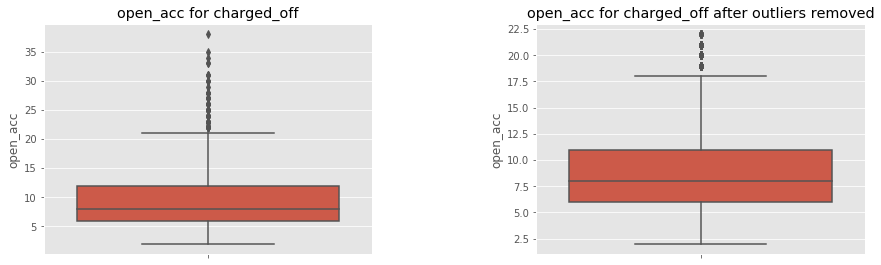

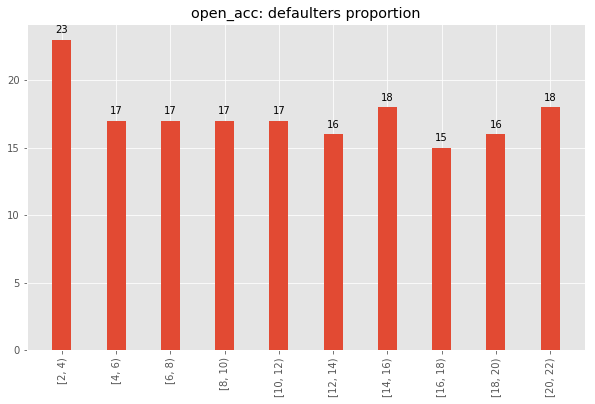

In [19]:
loans_chd_off.groupby('open_acc').size()
loans_chd_off['open_acc_bin'] = pd.cut(loans_chd_off.open_acc, list(range(2,26,2)), right=False)
loans_fy_paid['open_acc_bin'] = pd.cut(loans_fy_paid.open_acc, list(range(2,26,2)), right=False)

plt.subplot(1, 2, 1)
plt.title("open_acc for charged_off")
sns.boxplot(y='open_acc', data=loans_chd_off)

#remove outliers - his should ideally be done on the original data frame
loans_chd_off_f = loans_chd_off[loans_chd_off.open_acc < loans_chd_off.open_acc.quantile(0.99)]
loans_fy_paid_f = loans_fy_paid[loans_fy_paid.open_acc < loans_fy_paid.open_acc.quantile(0.99)]
plt.subplot(1, 2, 2)
plt.title("open_acc for charged_off after outliers removed")
sns.boxplot(y='open_acc', data=loans_chd_off_f)
plt.subplots_adjust(left=0.1, bottom=0.1, right=2.0, top=0.9, wspace=0.5, hspace=0.2)

bins1 = loans_chd_off_f.groupby('open_acc_bin').size()[:-1]
bins2 = loans_fy_paid_f.groupby('open_acc_bin').size()[:-1]
print(bins1)
print(bins2)
values = list(map(lambda x,y: round((x*100)/y), bins1, bins2 ))
cats = loans_chd_off_f.groupby('open_acc_bin').size().index.categories[:-1]
plt_hist(cats, values, 0.5, 0, "open_acc: defaulters proportion")

__Analysis summary for open_acc:__<br>
No particuar pattern observed in defaulters proportion

<center>Analysis of pub_rec column</center>

pub_rec
0    5160
1     457
2      10
dtype: int64
pub_rec
0    31347
1     1556
2       38
3        7
4        2
dtype: int64


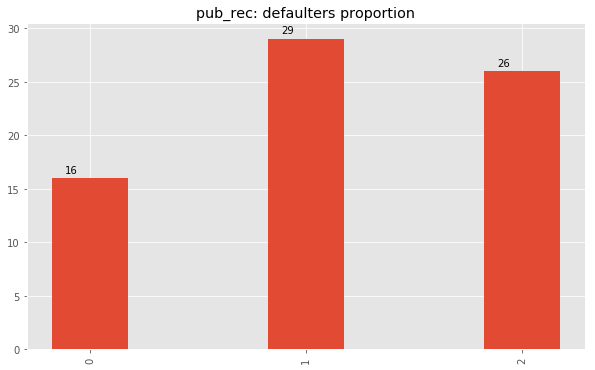

In [20]:
bins1 = loans_chd_off.groupby('pub_rec').size()
bins2 = loans_fy_paid.groupby('pub_rec').size()
print(bins1)
print(bins2)
values = list(map(lambda x,y: round((x*100)/y), bins1, bins2 ))
cats = loans_chd_off.groupby('pub_rec').size().index
plt_hist(cats, values, 0.5, 0, "pub_rec: defaulters proportion")

__Analysis summary for pub_rec:__<br>
From the plot shown it is clear that higher number of derogatory record indicates higher is the proportion of loan default<br>
Loan to applicants with more number of derogatory record would be riskier

<center>Analysis of pub_rec_bankruptcies column</center>

pub_rec_bankruptcies
0.0    5141
1.0     366
2.0       2
dtype: int64
pub_rec_bankruptcies
0.0    31097
1.0     1271
2.0        3
dtype: int64


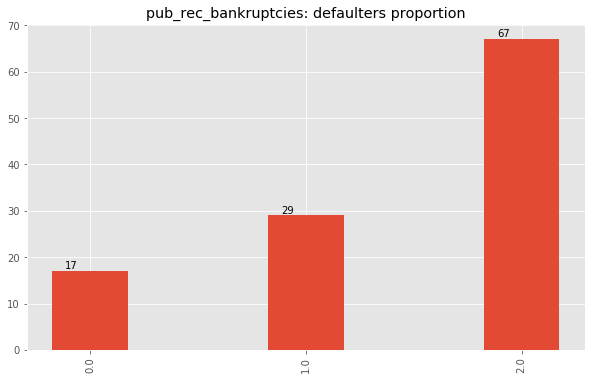

In [21]:
bins1 = loans_chd_off.groupby('pub_rec_bankruptcies').size()
bins2 = loans_fy_paid.groupby('pub_rec_bankruptcies').size()
print(bins1)
print(bins2)
values = list(map(lambda x,y: round((x*100)/y), bins1, bins2 ))
cats = loans_chd_off.groupby('pub_rec_bankruptcies').size().index
plt_hist(cats, values, 0.5, 0, "pub_rec_bankruptcies: defaulters proportion")

__Analysis summary for pub_rec_bankruptcies:__<br>
From the plot shown it is clear that higher number of bankruptcy record indicates higher is the proportion of loan default.<br>
Loan to applicants with more number of bankruptcy record would be riskier.

<center>Analysis of term column</center>

term
 36 months    3227
 60 months    2400
dtype: int64
term
 36 months    25869
 60 months     7081
dtype: int64


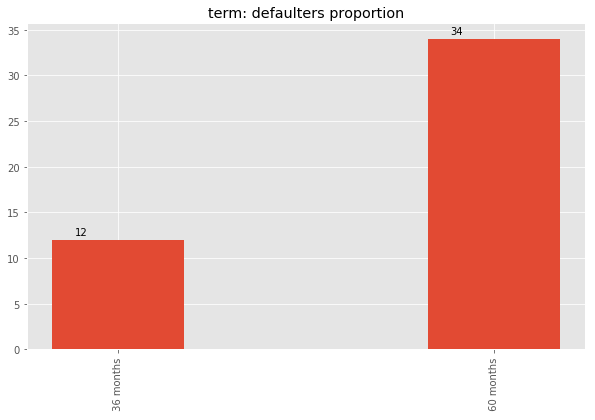

In [22]:
bins1 = loans_chd_off.groupby('term').size()
bins2 = loans_fy_paid.groupby('term').size()
print(bins1)
print(bins2)
values = list(map(lambda x,y: round((x*100)/y), bins1, bins2 ))
cats = loans_chd_off.groupby('term').size().index
plt_hist(cats, values, 0.5, 0, "term: defaulters proportion")

__Analysis summary for term:__<br>
From the plot shown it is clear that risk of default is higher for the 60 months tenure<br>
Loans having higher repayment tenure are riskier 

<center>Analysis of inq_last_6mths column</center>

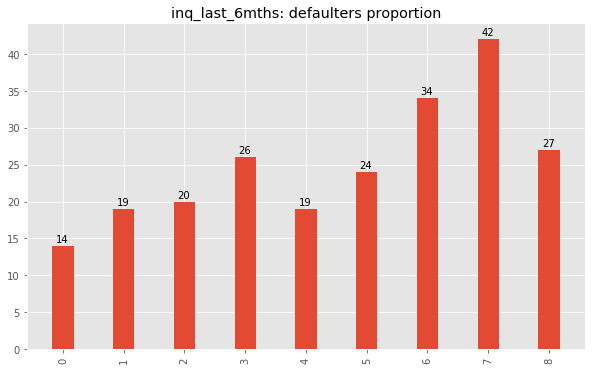

In [23]:
bins1 = loans_chd_off.groupby('inq_last_6mths').size()
bins2 = loans_fy_paid.groupby('inq_last_6mths').size()
values = list(map(lambda x,y: round((x*100)/y), bins1, bins2 ))
cats = loans_chd_off.groupby('inq_last_6mths').size().index
plt_hist(cats, values, 0.5, 0, "inq_last_6mths: defaulters proportion")

__Analysis summary for inq_last_6mths:__<br>
From the plot shown it is clear that there is an increasing trend of loan default with increasing number of inquiries.<br>
Higher number of recent inquiries make a loan riskier

<center>Analysis of total_pymnt column</center>

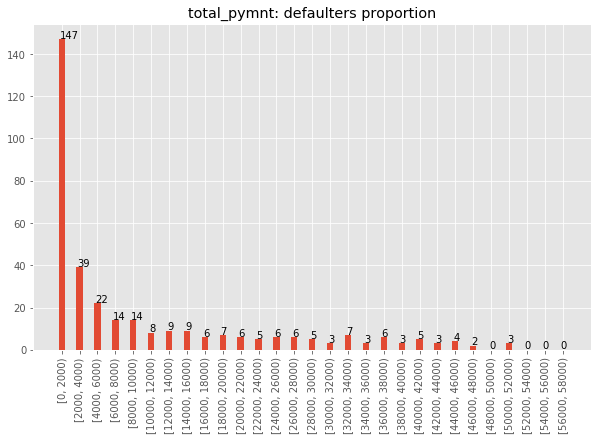

In [24]:
loans_chd_off.groupby('total_pymnt').size()
loans_chd_off['total_pymnt_bin'] = pd.cut(loans_chd_off.total_pymnt, list(range(0,60000,2000)), right=False)
loans_fy_paid['total_pymnt_bin'] = pd.cut(loans_fy_paid.total_pymnt, list(range(0,60000,2000)), right=False)
bins1 = loans_chd_off.groupby('total_pymnt_bin').size()
bins2 = loans_fy_paid.groupby('total_pymnt_bin').size()
values = list(map(lambda x,y: round((x*100)/y), bins1, bins2 ))
cats = loans_chd_off.groupby('total_pymnt_bin').size().index.categories
plt_hist(cats, values, 0.5, 0, "total_pymnt: defaulters proportion")

__Analysis summary for Total_pymnt:__<br>
Total payment received will be obviously lower for defaulters. Moreover this is not a parameter that can be used on new loan applicants

<center>Analysis of revol_util column</center>

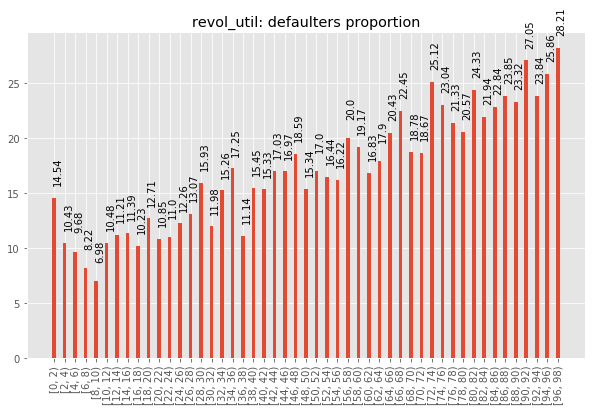

In [25]:
#Analysis of revol_util column: 

loans_chd_off['revol_util_bin'] = pd.cut(loans_chd_off.revol_util, list(range(0,100,2)), right=False)
loans_fy_paid['revol_util_bin'] = pd.cut(loans_fy_paid.revol_util, list(range(0,100,2)), right=False)
bins1 = loans_chd_off.groupby('revol_util_bin').size()
bins2 = loans_fy_paid.groupby('revol_util_bin').size()
values = list(map(lambda x,y: round((x*100)/y,2), bins1, bins2 ))
cats = loans_chd_off.groupby('revol_util_bin').size().index.categories
plt_hist(cats, values, 3, 90, "revol_util: defaulters proportion")

__Analysis summary for revol_util:__<br>
From the plot shown it is clear that higher the rate of revol_util, higher is the proportion of loan default<br>
A trend of higher loan default is seen with Higher values of revol_util 

<center>Analysis of addr_state column</center>

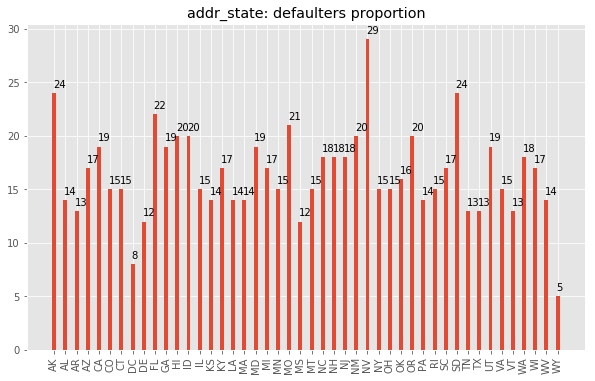

In [26]:
bins1 = loans_chd_off.groupby('addr_state').size().drop('NE')
bins2 = loans_fy_paid.groupby('addr_state').size().drop(['IA', 'IN', 'ME','NE'])
values = list(map(lambda x,y: round((x*100)/y), bins1, bins2 ))
cats = loans_chd_off.groupby('addr_state').size().index.drop('NE')
plt_hist(cats, values, 0.5, 0, "addr_state: defaulters proportion")

__Analysis summary for addr_state:__<br>
No particuar pattern observed in defaulters proportion